Import data

In [184]:
#Import data
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from IPython.display import HTML
from matplotlib import pyplot as plt
from scipy import stats as ss
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import StandardScaler, PowerTransformer
import statsmodels.formula.api as smf
from feature_engine.encoding import RareLabelEncoder
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder, MeanEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from feature_engine.selection import RecursiveFeatureAddition


pd.set_option('display.max_columns',30) #isso fará com que ao dar o comando df.head() eu consiga ver todas as colunas (onde esta 30 é o numero de colunas a serem exibidas)

Auxiliar function

In [3]:
def cramer_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2=chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    kcorr = k - ((k - 1)**2) / (n - 1)
    rcorr = r - ((k - 1)**2) / (n - 1)
    
    return np.sqrt(phi2corr / (min(kcorr - 1, rcorr - 1)))

Import data and Config

In [4]:
df1 = pd.read_csv('raw_data.csv')

1- Data Clean

In [5]:
df2 = df1.copy()

1.1 Exploring Data

In [6]:
df2.head().T

,0,1,2,3,4
escolaridade,NaN,nivel medio,nivel medio,NaN,NaN
renda_mensal_informal,NaN,1894.5078,NaN,NaN,NaN
dependentes,S,N,S,N,S
estado_civil,solteiro,solteiro,solteiro,casado(a) com comunhao de bens,solteiro
idade,36,39,26,23,33
conta_poupanca,S,S,S,N,S
conta_salario,N,N,N,N,N
qtd_fonte_renda,NaN,1.0,1.0,NaN,NaN
cheque_sem_fundo,S,N,N,S,S
conta_conjunta,N,N,N,N,N


1.2 - Data dimension

In [7]:
df2.shape

(50390, 21)

1.3 Removendo registros duplicados nas linhas

In [8]:
df2.drop_duplicates().shape #utilizando o shape para ver se houve alteração nos valores se comparando após remoçao de duplicadas e antes

(50390, 21)

1.4 Column type (para analisar se teremos que alterar algum tipo)

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   escolaridade                 14615 non-null  object 
 1   renda_mensal_informal        9768 non-null   float64
 2   dependentes                  50390 non-null  object 
 3   estado_civil                 50390 non-null  object 
 4   idade                        50390 non-null  int64  
 5   conta_poupanca               50390 non-null  object 
 6   conta_salario                50390 non-null  object 
 7   qtd_fonte_renda              12806 non-null  float64
 8   cheque_sem_fundo             50390 non-null  object 
 9   conta_conjunta               50390 non-null  object 
 10  valor_conta_corrente         0 non-null      float64
 11  valor_conta_poupanca         0 non-null      float64
 12  valor_emprestimo             50390 non-null  float64
 13  multa           

1.5 Alterando tipo das variaveis

In [10]:
df2['data'] = df2['data'].astype('datetime64[ns]')

1.6 Checando % de dados NaN em cada coluna

In [11]:
df2.isna().sum()/len(df2)

escolaridade                   0.709962
renda_mensal_informal          0.806152
dependentes                    0.000000
estado_civil                   0.000000
idade                          0.000000
conta_poupanca                 0.000000
conta_salario                  0.000000
qtd_fonte_renda                0.745862
cheque_sem_fundo               0.000000
conta_conjunta                 0.000000
valor_conta_corrente           1.000000
valor_conta_poupanca           1.000000
valor_emprestimo               0.000000
multa                          0.000000
juros                          0.000000
valor_emprestimo_atualizado    0.000000
pago                           0.000000
id                             0.000000
genero                         0.000000
data                           0.000000
estado                         0.000000
dtype: float64

1.7 removendo colunas com  100% de Na (nesse projeto excluirei tambem os casos com % proximos a 100)

In [12]:
df2 = df2.drop(['valor_conta_corrente','valor_conta_poupanca'], axis = 1)
df2 = df2.drop(['escolaridade', 'renda_mensal_informal','qtd_fonte_renda'], axis = 1)

2- Estatística Descritiva

2.1 Separar dados em Variáveis categoricas e Variáveis númericas

In [13]:
num_attributes = df2.select_dtypes(include=['int32','int64','float32','float64'])
cat_attributes = df2.select_dtypes(exclude=['int32','int64','float32','float64', 'datetime64[ns]'])

2.2 Analisando as variaveis númericas

In [14]:
#Tendencia central (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersão (std, min, max, range, skew, kurtosis)
d1 = pd.DataFrame (num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame (num_attributes.apply( min )).T
d3 = pd.DataFrame (num_attributes.apply( max ) ).T
d4 = pd.DataFrame (num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame (num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame (num_attributes.apply( lambda  x: x.kurtosis() ) ).T

#Concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index() 
m.columns = (['attributes','min', 'max', 'range','mean','median','std','skew','kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,1.800000e+01,1.130000e+02,9.500000e+01,3.172453e+01,3.000000e+01,8.565032e+00,1.959951,7.223175
1,valor_emprestimo,1.393000e+03,2.867894e+08,2.867880e+08,5.198887e+04,2.298035e+03,1.588803e+06,135.859233,22605.724510
2,multa,0.000000e+00,5.737759e+08,5.737759e+08,6.022658e+04,6.489650e+02,2.843913e+06,171.305766,33333.600930
3,juros,0.000000e+00,5.703619e+08,5.703619e+08,6.485391e+04,1.143320e+03,2.728143e+06,184.431138,38002.805365
4,valor_emprestimo_atualizado,1.397040e+03,1.430927e+09,1.430926e+09,1.770694e+05,5.652695e+03,7.058294e+06,171.822788,33820.743108
5,id,1.000172e+08,9.999988e+08,8.999816e+08,5.485969e+08,5.482058e+08,2.601475e+08,0.007412,-1.203943


In [15]:
num_attributes.describe(percentiles=[0.99,0.95,0.75,0.5]).T
#Este resumo estatístico incluirá contagem, média, desvio padrão, mínimo, percentis 25%, 50%, 75%, 95% e 99%, e máximo para cada coluna do DataFrame.
#Por exemplo, o percentil 95 (0.95) indica o valor abaixo do qual 95% dos dados estão contidos, enquanto o percentil 99 indica o valor abaixo do qual 99% dos dados estão contidos.

,count,mean,std,min,50%,75%,95%,99%,max
idade,50390.0,3.172453e+01,8.565117e+00,1.800000e+01,3.000000e+01,3.500000e+01,4.800000e+01,6.200000e+01,1.130000e+02
valor_emprestimo,50390.0,5.198887e+04,1.588819e+06,1.393000e+03,2.298035e+03,7.172175e+03,5.879202e+04,4.464769e+05,2.867894e+08
multa,50390.0,6.022658e+04,2.843941e+06,0.000000e+00,6.489650e+02,3.600000e+03,6.189092e+04,5.039267e+05,5.737759e+08
juros,50390.0,6.485391e+04,2.728170e+06,0.000000e+00,1.143320e+03,5.545427e+03,8.235361e+04,6.408426e+05,5.703619e+08
valor_emprestimo_atualizado,50390.0,1.770694e+05,7.058364e+06,1.397040e+03,5.652695e+03,1.903061e+04,2.006742e+05,1.586720e+06,1.430927e+09
id,50390.0,5.485969e+08,2.601500e+08,1.000172e+08,5.482058e+08,7.737146e+08,9.542667e+08,9.912031e+08,9.999988e+08


2.2 Analisando as variaveis categoricas

In [16]:
for i in cat_attributes.columns:
    print(cat_attributes[i].value_counts(normalize=True)) #resultados normalizados, significa que os valores são ajustados de forma que a soma deles seja igual a 1, representando assim proporções ou porcentagens relativas.
    print('\n----------\n') #\n é usado para saltar uma linha de espaço

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64

----------

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64

----------

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64

----------

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64

----------

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64

----------

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64

----------

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

----------

genero


In [17]:
df3 = df2.copy()

3- MindMap

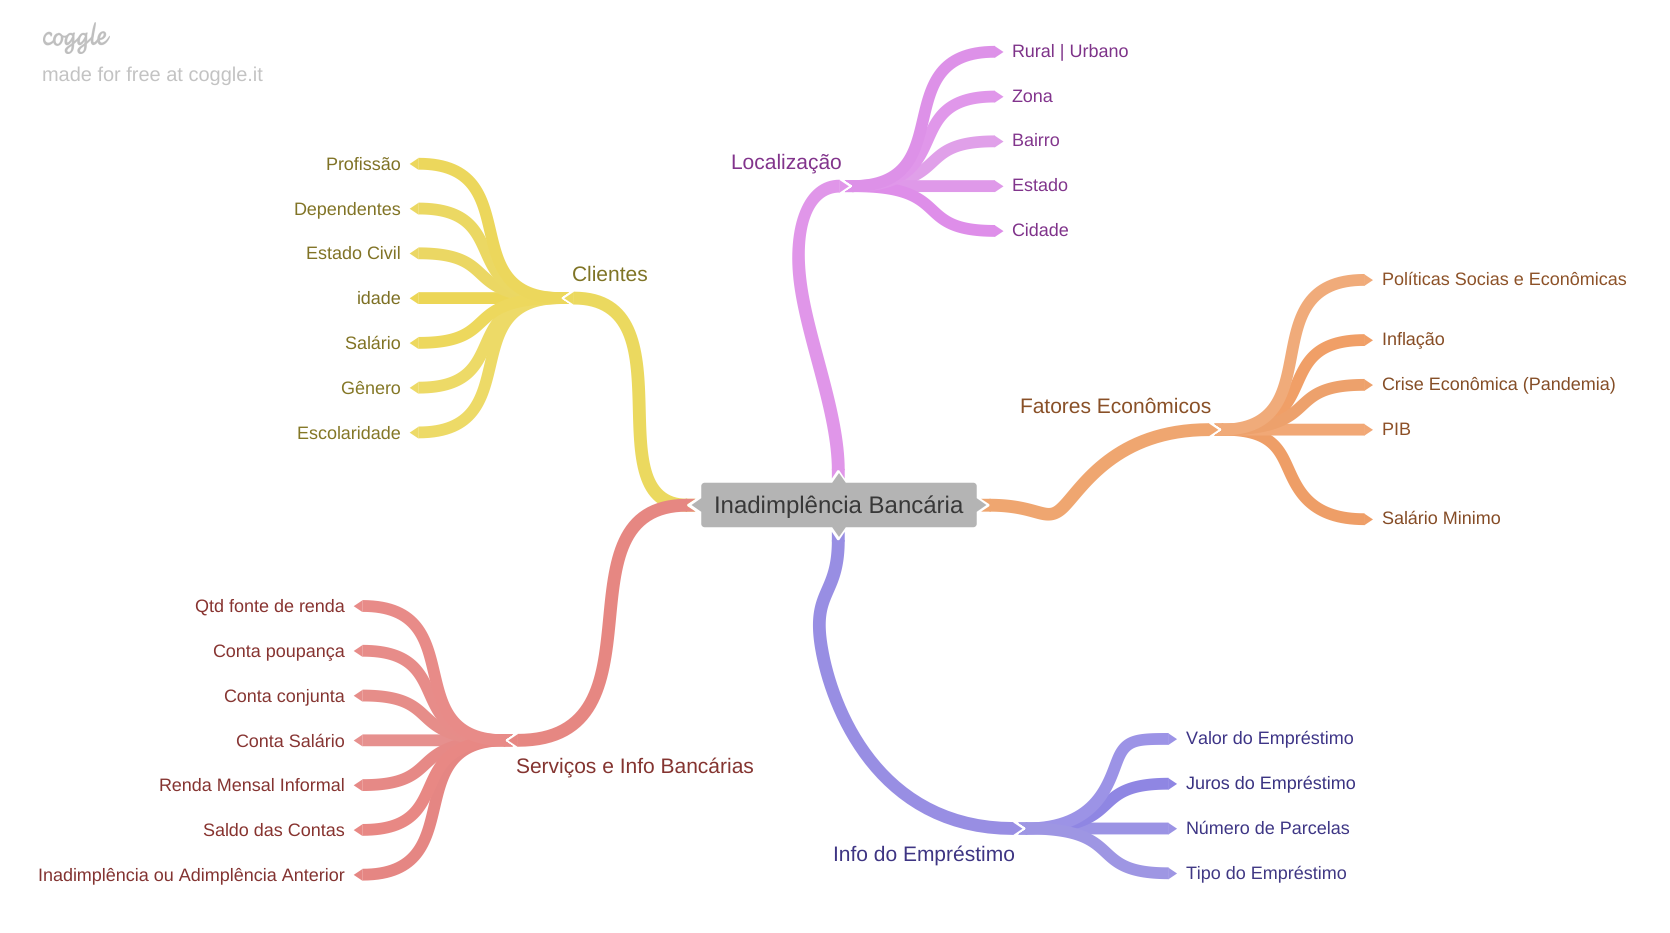

In [18]:
Image('MindMap.png')

3.1 Hipoteses

 ###Hipóteses de Informações dos Clientes
 1. Mulheres são em média 10% mais ADIMPLENTES.
 2. Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.
 3. Clientes com Dependentes são em média 15% mais ADIMPLENTES.
 4. Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.
 
 ###Hipóteses de Informações Bancárias
 5. Clientes com conta salário são em média 30% mais ADIMPLENTES.
 6. Clientes com conta poupança são em média 10% mais ADIMPLENTES.
 7. Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.
 8. Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.
 
 ###Hipóteses de Informações do Empréstimo
 9. Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.
 
 ###Hipóteses de Informações de Localização
 10. Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG

4- Engenharia de Variáveis

4.1 Feature juros percentual

In [19]:
df3['juros_porcentagem'] = df3['juros']/df3['valor_emprestimo']
df3.head()

,dependentes,estado_civil,idade,conta_poupanca,conta_salario,cheque_sem_fundo,conta_conjunta,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,data,estado,juros_porcentagem
0,S,solteiro,36,S,N,S,N,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,2020-01-01,minas gerais,0.715042
1,N,solteiro,39,S,N,N,N,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,2020-01-01,espirito santo,0.183175
2,S,solteiro,26,S,N,N,N,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,2020-01-01,sao paulo,0.610616
3,N,casado(a) com comunhao de bens,23,N,N,S,N,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,2020-01-01,sao paulo,2.092722
4,S,solteiro,33,S,N,S,N,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,2020-01-01,espirito santo,0.022295


4.2  Feature de quantidade de empréstimos feito por cliente

In [20]:
contagem_emprestimos = df3.groupby('id')['valor_emprestimo'].count()

# Calcular a moda dos valores de empréstimo
valor_emprestimo_moda = contagem_emprestimos.mode()[0]

print(f"Valor mais recorrente da quantidade de valor emprestimo: {valor_emprestimo_moda}")


Valor mais recorrente da quantidade de valor emprestimo: 1


feature se os clientes foram Inadimplentes ou Adimplentes no empréstimo anterior.

In [21]:
# Clientes Adimplentes (sem multa)
adimplentes = df3.loc[df3["multa"] == 0, "id"].nunique()
print(f"Quantidade de clientes adimplentes: {adimplentes}")

# Clientes Inadimplentes (com multa)
inadimplentes = df3.loc[df3['multa'] != 0, 'id'].nunique()
print(f"Quantidade de clientes inadimplentes: {inadimplentes}")

Quantidade de clientes adimplentes: 106
Quantidade de clientes inadimplentes: 50284


5- EDA Univariada

In [22]:
df4=df3.copy()

ANALISANDO VARIAVEIS NÚMERICAS

In [23]:
num_attributes= df4.select_dtypes(include=['int32','int64','float32','float64'])

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'valor_emprestimo'}>],
       [<Axes: title={'center': 'multa'}>,
        <Axes: title={'center': 'juros'}>],
       [<Axes: title={'center': 'valor_emprestimo_atualizado'}>,
        <Axes: title={'center': 'juros_porcentagem'}>]], dtype=object)

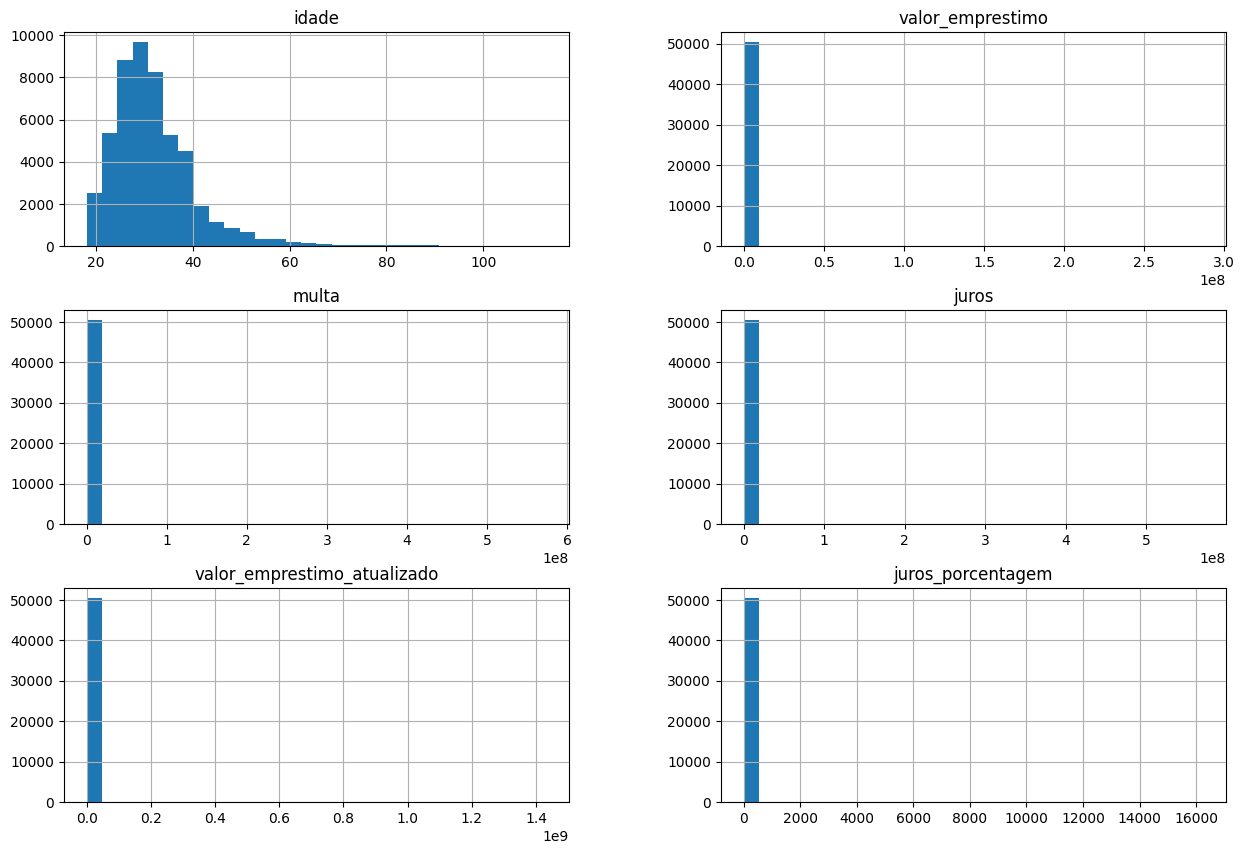

In [24]:
num_attributes.drop('id',axis=1).hist(bins=30,figsize=(15,10))

Variavel: IDADE

In [25]:
print(df4['idade'].describe())

count    50390.000000
mean        31.724529
std          8.565117
min         18.000000
25%         26.000000
50%         30.000000
75%         35.000000
max        113.000000
Name: idade, dtype: float64


Text(0.5, 1.0, 'boxplot')

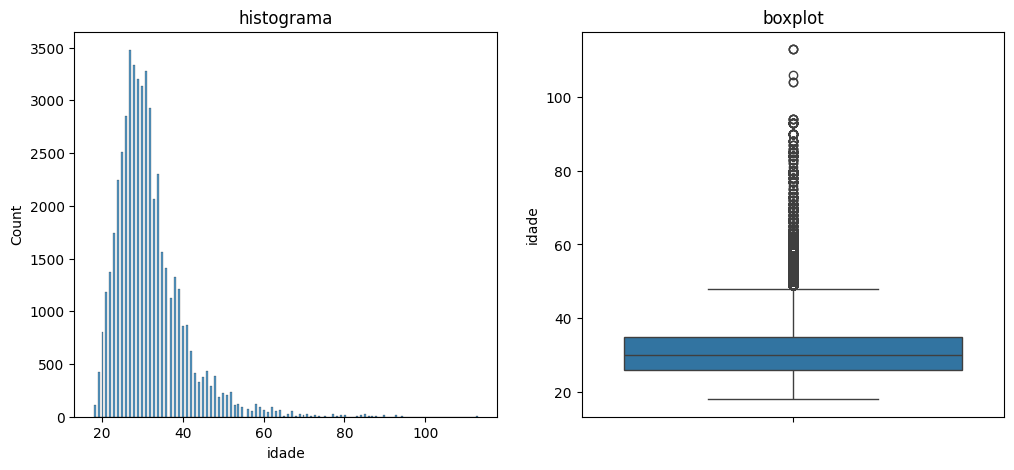

In [26]:
fig,axes = plt.subplots(1,2,figsize=(12,5))


sns.histplot(df4['idade'],ax=axes[0])
axes[0].set_title('histograma')


sns.boxplot(df4['idade'],ax=axes[1])
axes[1].set_title('boxplot')

Variavel: EMPRESTIMO

In [27]:
print(df4['valor_emprestimo'].describe())

count    5.039000e+04
mean     5.198887e+04
std      1.588819e+06
min      1.393000e+03
25%      1.622370e+03
50%      2.298035e+03
75%      7.172175e+03
max      2.867894e+08
Name: valor_emprestimo, dtype: float64


Text(0.5, 1.0, 'boxplot')

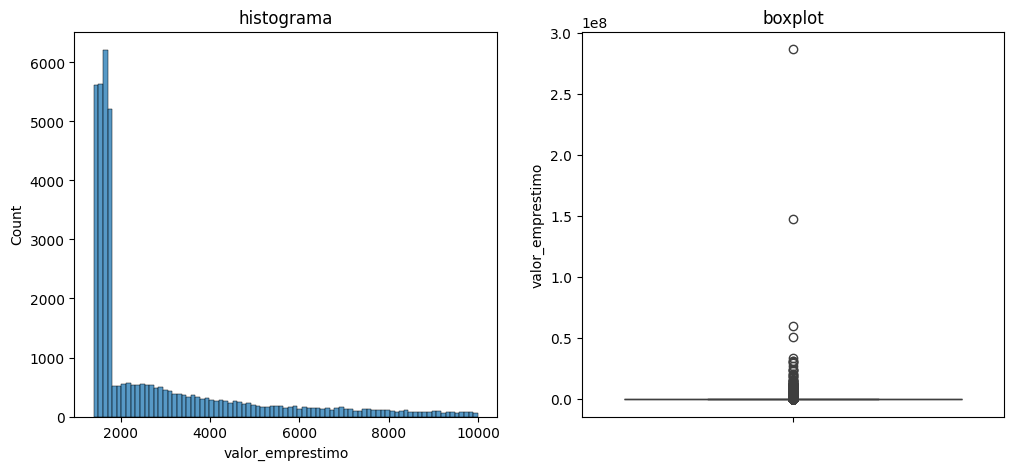

In [28]:
fig,axes = plt.subplots(1,2,figsize=(12,5))


sns.histplot(df4[df4['valor_emprestimo']<10000]['valor_emprestimo'],ax=axes[0])
axes[0].set_title('histograma')


sns.boxplot(df4['valor_emprestimo'],ax=axes[1])
axes[1].set_title('boxplot')

Variavel: MULTA

In [29]:
print(df4['multa'].describe())

count    5.039000e+04
mean     6.022658e+04
std      2.843941e+06
min      0.000000e+00
25%      1.325675e+02
50%      6.489650e+02
75%      3.600000e+03
max      5.737759e+08
Name: multa, dtype: float64


Text(0.5, 1.0, 'boxplot')

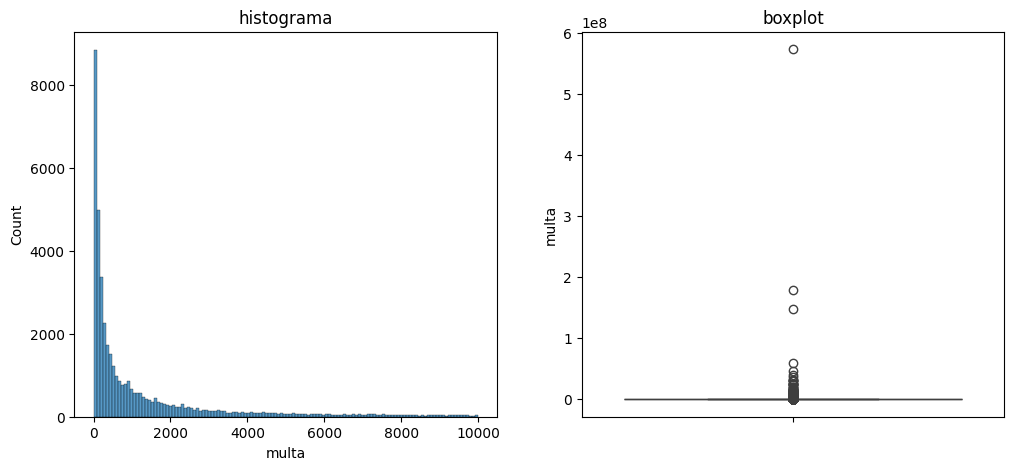

In [30]:
fig,axes = plt.subplots(1,2,figsize=(12,5))


sns.histplot(df4[df4['multa']<10000]['multa'],ax=axes[0])
axes[0].set_title('histograma')


sns.boxplot(df4['multa'],ax=axes[1])
axes[1].set_title('boxplot')

Variavel: JUROS

In [31]:
print(df4['juros'].describe())

count    5.039000e+04
mean     6.485391e+04
std      2.728170e+06
min      0.000000e+00
25%      2.742725e+02
50%      1.143320e+03
75%      5.545427e+03
max      5.703619e+08
Name: juros, dtype: float64


Text(0.5, 1.0, 'boxplot')

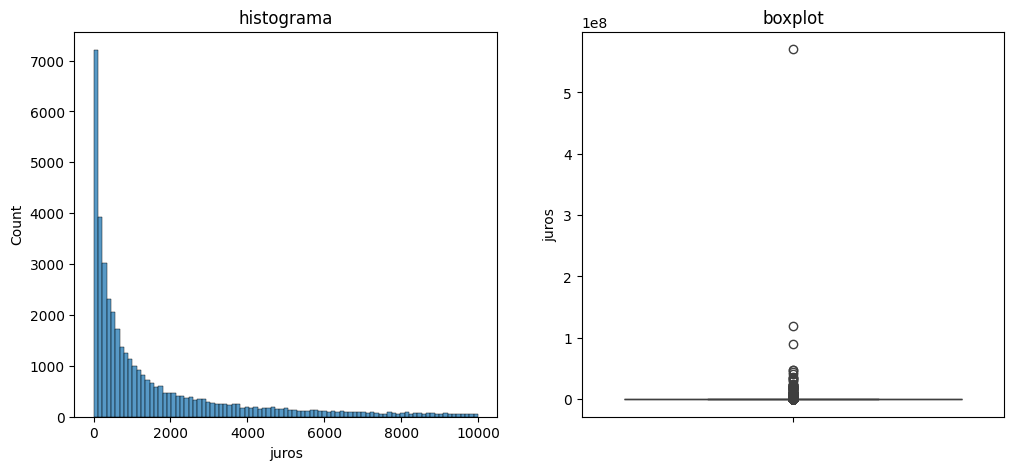

In [32]:
fig,axes = plt.subplots(1,2,figsize=(12,5))


sns.histplot(df4[df4['juros']<10000]['juros'],ax=axes[0])
axes[0].set_title('histograma')


sns.boxplot(df4['juros'],ax=axes[1])
axes[1].set_title('boxplot')

Variavel: VALOR EMPRESTIMO ATUALIZADO

In [33]:
print(df4['valor_emprestimo_atualizado'].describe())

count    5.039000e+04
mean     1.770694e+05
std      7.058364e+06
min      1.397040e+03
25%      2.842910e+03
50%      5.652695e+03
75%      1.903061e+04
max      1.430927e+09
Name: valor_emprestimo_atualizado, dtype: float64


Text(0.5, 1.0, 'boxplot')

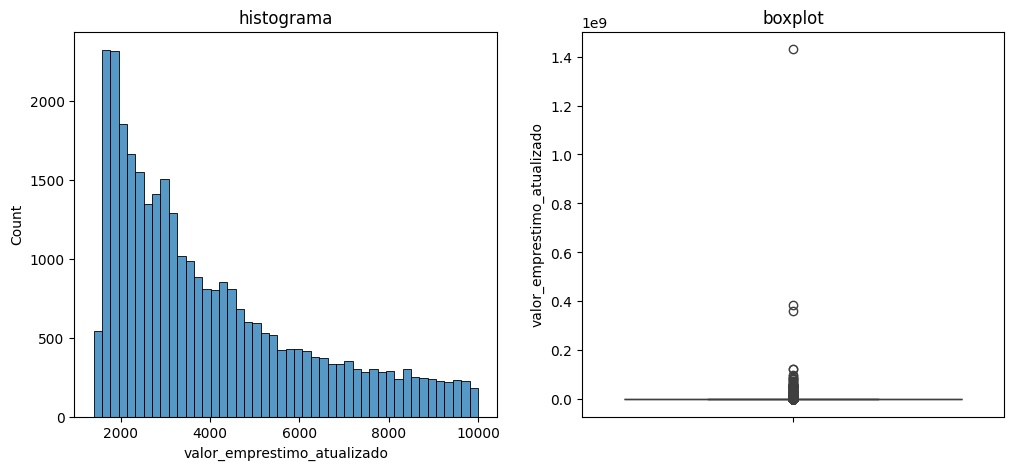

In [34]:
fig,axes = plt.subplots(1,2,figsize=(12,5))


sns.histplot(df4[df4['valor_emprestimo_atualizado']<10000]['valor_emprestimo_atualizado'],ax=axes[0])
axes[0].set_title('histograma')


sns.boxplot(df4['valor_emprestimo_atualizado'],ax=axes[1])
axes[1].set_title('boxplot')

Variavel: JUROS EM PORCENTAGEM

In [35]:
print(df4['juros_porcentagem'].describe())

count    50390.000000
mean         3.029730
std        105.423189
min          0.000000
25%          0.112590
50%          0.349677
75%          0.848668
max      16248.020882
Name: juros_porcentagem, dtype: float64


Text(0.5, 1.0, 'boxplot')

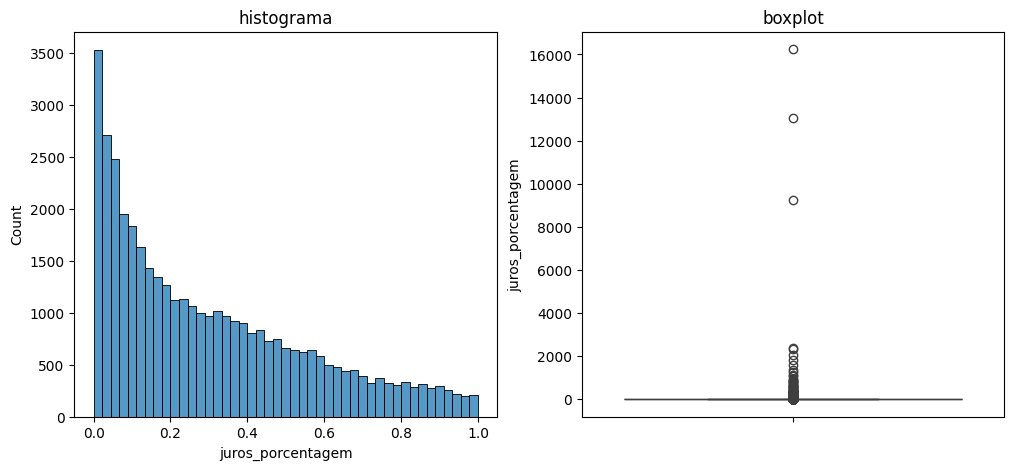

In [36]:
fig,axes = plt.subplots(1,2,figsize=(12,5))


sns.histplot(df4[df4['juros_porcentagem']<1]['juros_porcentagem'],ax=axes[0])
axes[0].set_title('histograma')


sns.boxplot(df4['juros_porcentagem'],ax=axes[1])
axes[1].set_title('boxplot')

ANALISANDO VARIAVEIS CATEGORICAS

variavel: DEPENDENTES

In [37]:
df4['dependentes'].value_counts(normalize=True)

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64

<Axes: xlabel='dependentes', ylabel='count'>

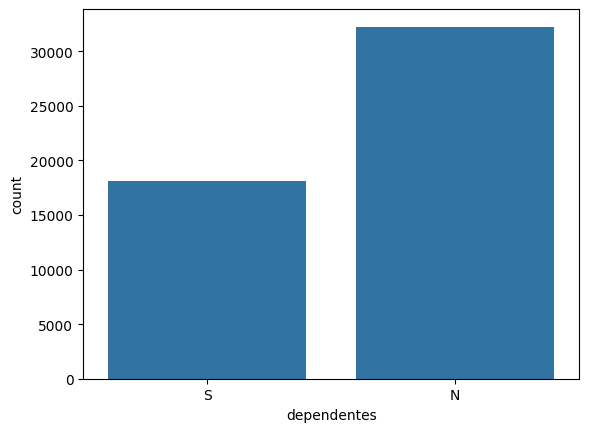

In [38]:
sns.countplot(x='dependentes',data=df4)

variavel: ESTADO CIVIL

In [39]:
df4['estado_civil'].value_counts(normalize=True)

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'solteiro'),
  Text(1, 0, 'casado(a) com comunhao de bens'),
  Text(2, 0, 'casado(a) com comunhao parcial de bens'),
  Text(3, 0, 'casado(a) com separacao de bens'),
  Text(4, 0, 'divorciado'),
  Text(5, 0, 'separado judicialmente'),
  Text(6, 0, 'viuvo(a)'),
  Text(7, 0, 'outros')])

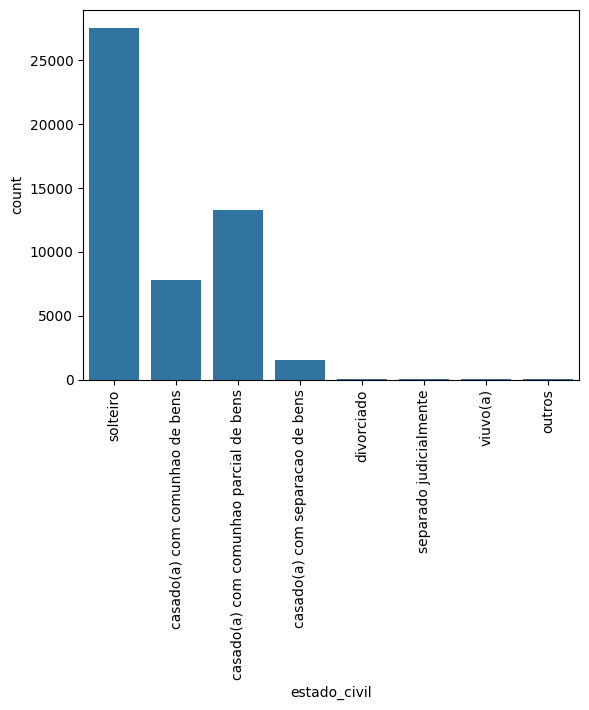

In [40]:
sns.countplot(x='estado_civil',data=df4)
plt.xticks(rotation=90) #rotaciona os nomes dos rotulos em 90 graus

variavel: CONTA POUPANÇA

In [41]:
df4['conta_poupanca'].value_counts(normalize=True)

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64

<Axes: xlabel='conta_poupanca', ylabel='count'>

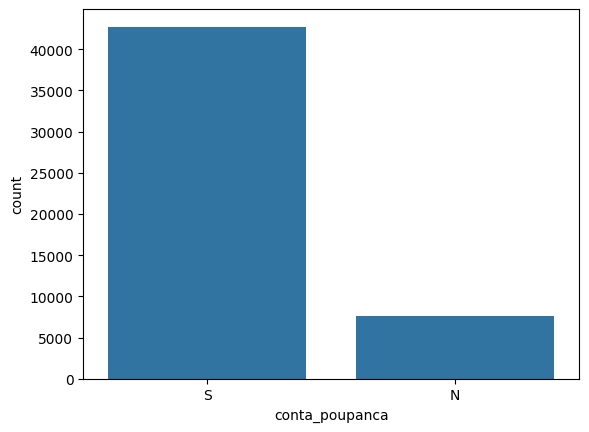

In [42]:
sns.countplot(x='conta_poupanca',data=df4)

variavel: CONTA SALÁRIO

In [43]:
df4['conta_salario'].value_counts(normalize=True)

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64

<Axes: xlabel='conta_salario', ylabel='count'>

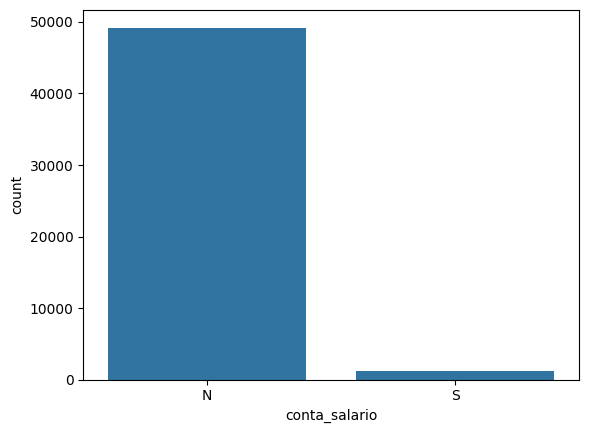

In [44]:
sns.countplot(x='conta_salario',data=df4)

variavel: CHEQUE SEM FUNDO

In [45]:
df4['cheque_sem_fundo'].value_counts(normalize=True)

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64

<Axes: xlabel='cheque_sem_fundo', ylabel='count'>

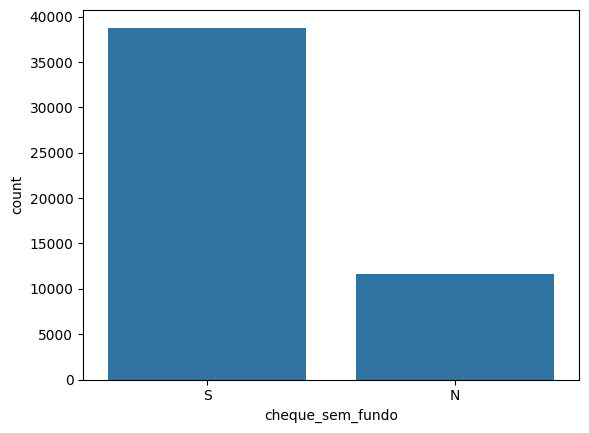

In [46]:
sns.countplot(x='cheque_sem_fundo',data=df4)

variavel: CONTA CONJUNTA

In [47]:
df4['conta_conjunta'].value_counts(normalize=True)

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64

<Axes: xlabel='conta_conjunta', ylabel='count'>

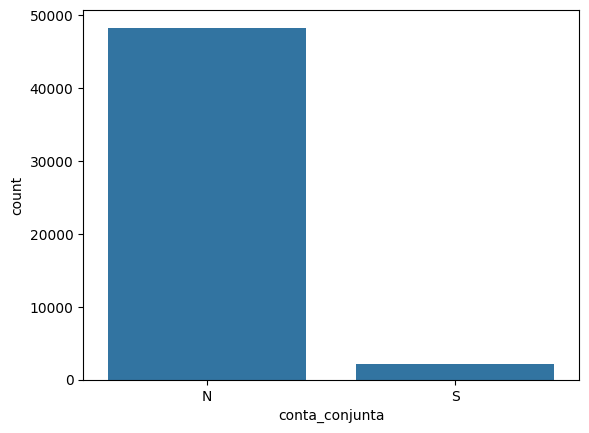

In [48]:
sns.countplot(x='conta_conjunta',data=df4)

variavel: PAGO

In [49]:
df4['pago'].value_counts(normalize=True)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

<Axes: xlabel='pago', ylabel='count'>

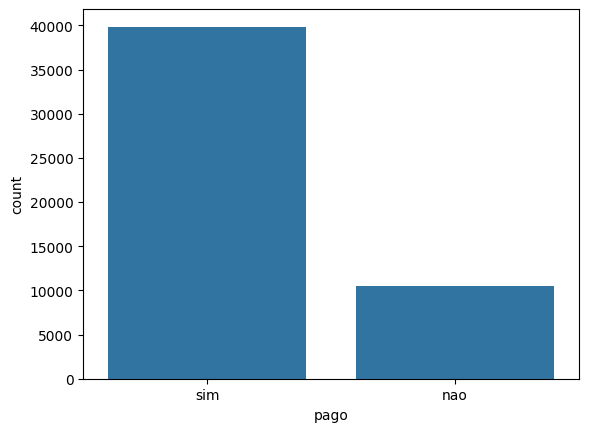

In [50]:
sns.countplot(x='pago',data=df4)

variavel: GENÊRO

In [51]:
df4['genero'].value_counts(normalize=True)

genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64

<Axes: xlabel='genero', ylabel='count'>

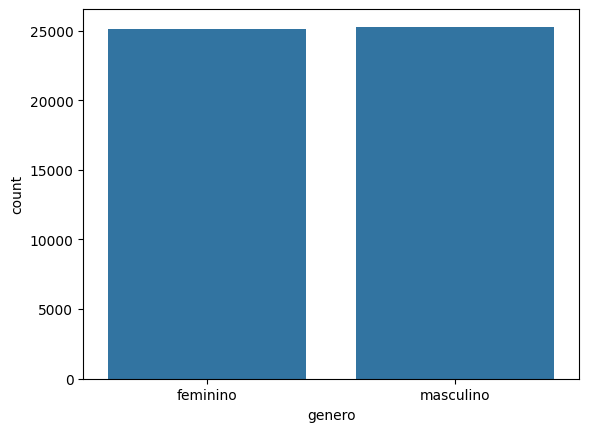

In [52]:
sns.countplot(x='genero',data=df4)

variavel: ESTADO

In [53]:
df4['estado'].value_counts(normalize=True)

estado
minas gerais      0.251340
sao paulo         0.250189
espirito santo    0.249772
rio de janeiro    0.248700
Name: proportion, dtype: float64

([0, 1, 2, 3],
 [Text(0, 0, 'minas gerais'),
  Text(1, 0, 'espirito santo'),
  Text(2, 0, 'sao paulo'),
  Text(3, 0, 'rio de janeiro')])

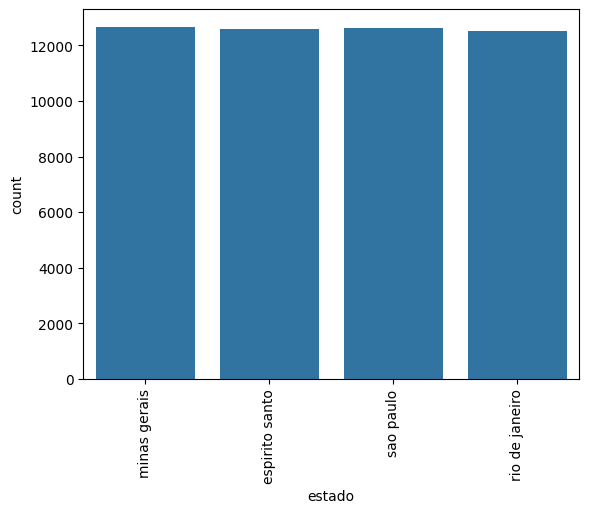

In [54]:
sns.countplot(x='estado',data=df4)
plt.xticks(rotation=90) #rotaciona os nomes dos rotulos em 90 graus

6 - CLEAN OUTLIERS

In [55]:
df5 = df4.copy()

o modelo ajudará apenas em caso de emprestimos abaixo de um valor especifico (defini abaixo de 5milhoes) a cima desse valor será avaliado por analistas.
alem disso o modelo só vai ajudar em casos de percentual de juros menor que 0.01
quero ver quanto da base vou eliminar caso eu remova eles

% de dados a cima do valor limite de 5milhoes

In [56]:
len(df5[df5['valor_emprestimo']>5000000])/len(df5)

0.0015479261758285373

% de dados a abaixo de 0.01

In [57]:
len(df5[df5['juros_porcentagem']<0.01])/len(df5)

0.03464973208970034

juntos representam um valor pequeno da base e que não representa vies no data set (para garantir isso após a limpeza posso rodar novamente a analise de uma das variaveis e ver se a proporção alterou muito, se não tiver alterado otimo!), então vou remove-los

In [58]:
df5 = (df5[df5['valor_emprestimo']<5000000]).copy()
df5 = (df5[df5['juros_porcentagem']>0.01]).copy()

7- EDA BIVARIADA - verificando hipoteses

In [59]:
df6 = df5.copy()

Mulheres são em média 10% mais ADIMPLENTES. FALSO

In [60]:
pd.crosstab(df6['genero'],df6['pago']) #valor absoluto


pago,nao,sim
genero,,
feminino,5220,18992
masculino,5121,19233


In [61]:
pd.crosstab(df6['genero'],df6['pago'],normalize = 'index') #valor percentual, normalizado para que a soma de 1

pago,nao,sim
genero,,
feminino,0.215596,0.784404
masculino,0.210273,0.789727


<Axes: xlabel='genero'>

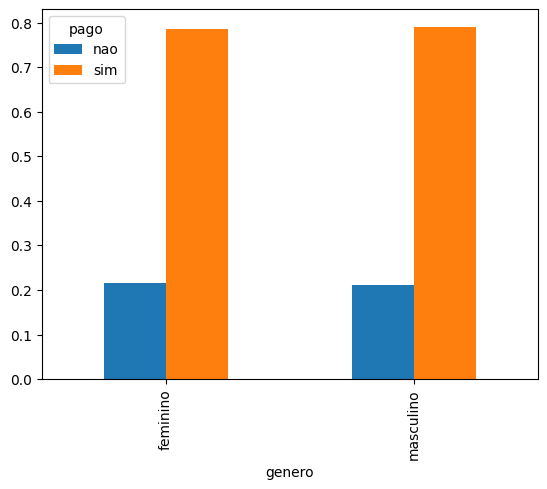

In [62]:
pd.crosstab(df6['genero'],df6['pago'],normalize='index').plot(kind='bar')

Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES. FALSO

In [63]:
# Função para categorizar a idade
def categorize_idade(idade):
    if idade <= 59:
        return 'Até 59 anos'
    else:
        return '60 anos ou mais'

# Adicionando uma nova coluna 'categoria_idade' ao DataFrame
df6['categoria_idade'] = df6['idade'].apply(categorize_idade)

# Agora você pode usar pd.crosstab para analisar as categorias de idade
crosstab_result = pd.crosstab(df6['categoria_idade'], df6['pago'])#normalize='index'
print(crosstab_result)

pago               nao    sim
categoria_idade              
60 anos ou mais    229    414
Até 59 anos      10112  37811


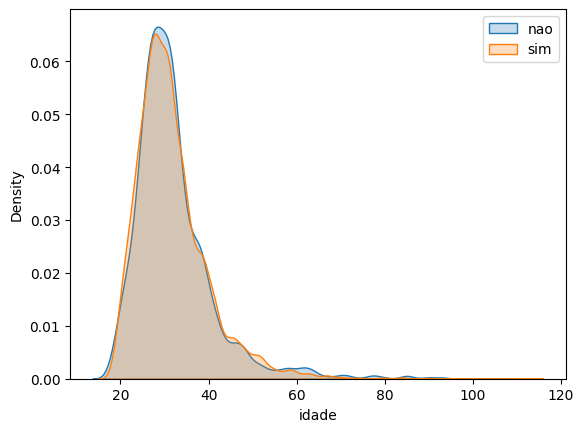

In [64]:
sns.kdeplot(df6[df6['pago']=='nao']['idade'],label='nao',fill=True)
sns.kdeplot(df6[df6['pago']=='sim']['idade'],label='sim',fill=True)
plt.legend()

<Axes: xlabel='idade_binned'>

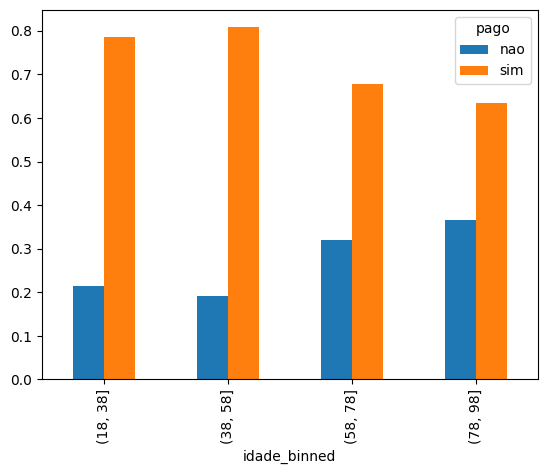

In [65]:
bins = list(np.arange(18,115,20))
aux=df6.copy(0)

aux['idade_binned']=pd.cut(aux['idade'],bins=bins)


pd.crosstab(aux['idade_binned'],aux['pago'],normalize='index').plot(kind='bar')

Clientes com Dependentes são em média 15% mais ADIMPLENTES. VERDADEIRA

pago,nao,sim
dependentes,,
N,8661,22568
S,1680,15657


pago,nao,sim
dependentes,,
N,0.277338,0.722662
S,0.096903,0.903097


<Axes: xlabel='dependentes'>

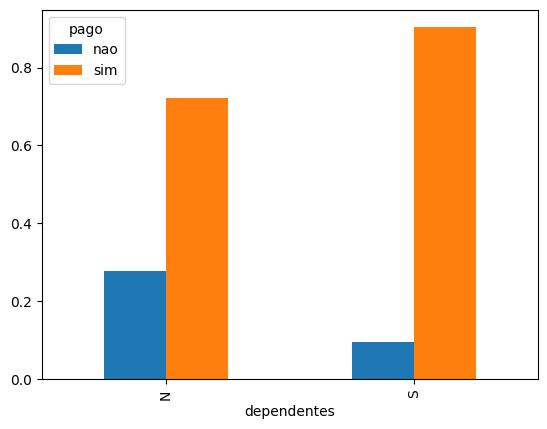

In [66]:
display(pd.crosstab(aux['dependentes'],aux['pago']))
display(pd.crosstab(aux['dependentes'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['dependentes'],aux['pago'],normalize='index').plot(kind='bar'))

Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais. FALSO

pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,1790,5825
casado(a) com comunhao parcial de bens,5112,8003
casado(a) com separacao de bens,401,1105
divorciado,6,56
outros,27,7
separado judicialmente,33,41
solteiro,2949,23170
viuvo(a),23,18


pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,0.235062,0.764938
casado(a) com comunhao parcial de bens,0.389783,0.610217
casado(a) com separacao de bens,0.266268,0.733732
divorciado,0.096774,0.903226
outros,0.794118,0.205882
separado judicialmente,0.445946,0.554054
solteiro,0.112906,0.887094
viuvo(a),0.560976,0.439024


<Axes: xlabel='estado_civil'>

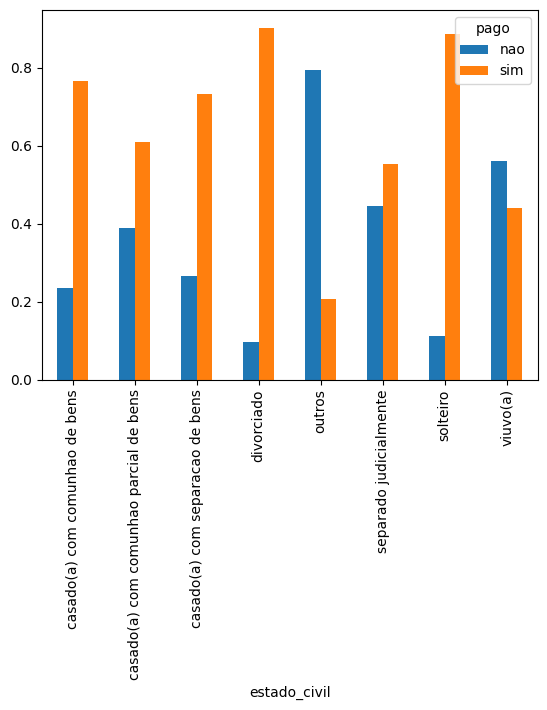

In [67]:
display(pd.crosstab(aux['estado_civil'],aux['pago']))
display(pd.crosstab(aux['estado_civil'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['estado_civil'],aux['pago'],normalize='index').plot(kind='bar'))

Clientes com conta salário são em média 30% mais ADIMPLENTES. FALSO

pago,nao,sim
conta_salario,,
N,10030,37403
S,311,822


pago,nao,sim
conta_salario,,
N,0.211456,0.788544
S,0.274492,0.725508


<Axes: xlabel='conta_salario'>

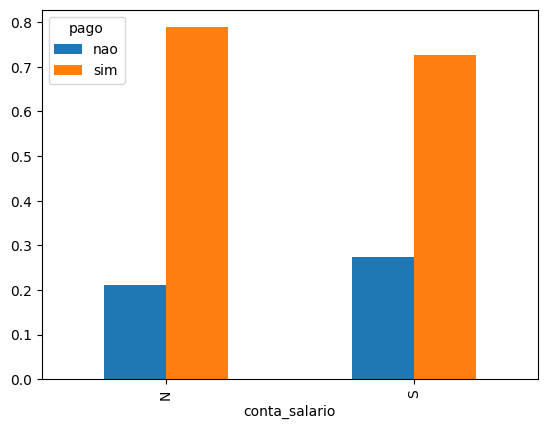

In [68]:
display(pd.crosstab(aux['conta_salario'],aux['pago']))
display(pd.crosstab(aux['conta_salario'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['conta_salario'],aux['pago'],normalize='index').plot(kind='bar'))

Clientes com conta poupança são em média 10% mais ADIMPLENTES. FALSO

pago,nao,sim
conta_poupanca,,
N,1847,5648
S,8494,32577


pago,nao,sim
conta_poupanca,,
N,0.246431,0.753569
S,0.206813,0.793187


<Axes: xlabel='conta_poupanca'>

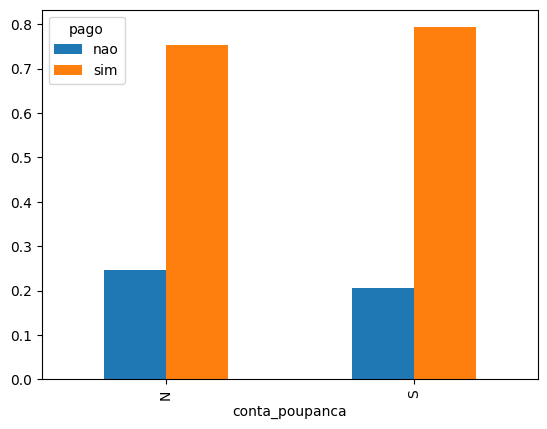

In [69]:
display(pd.crosstab(aux['conta_poupanca'],aux['pago']))
display(pd.crosstab(aux['conta_poupanca'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['conta_poupanca'],aux['pago'],normalize='index').plot(kind='bar'))   

Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES FALSO

pago,nao,sim
cheque_sem_fundo,,
N,1051,9958
S,9290,28267


pago,nao,sim
cheque_sem_fundo,,
N,0.095467,0.904533
S,0.247357,0.752643


<Axes: xlabel='cheque_sem_fundo'>

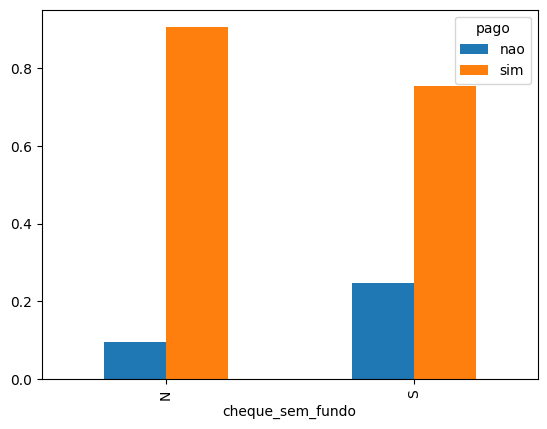

In [70]:
display(pd.crosstab(aux['cheque_sem_fundo'],aux['pago']))
display(pd.crosstab(aux['cheque_sem_fundo'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['cheque_sem_fundo'],aux['pago'],normalize='index').plot(kind='bar'))   

Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES. FALSO

pago,nao,sim
conta_conjunta,,
N,10085,36489
S,256,1736


pago,nao,sim
conta_conjunta,,
N,0.216537,0.783463
S,0.128514,0.871486


<Axes: xlabel='conta_conjunta'>

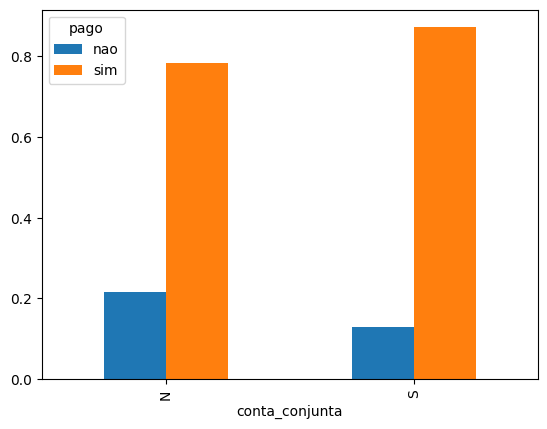

In [71]:
display(pd.crosstab(aux['conta_conjunta'],aux['pago']))
display(pd.crosstab(aux['conta_conjunta'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['conta_conjunta'],aux['pago'],normalize='index').plot(kind='bar'))   

clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES. VERDADEIRO

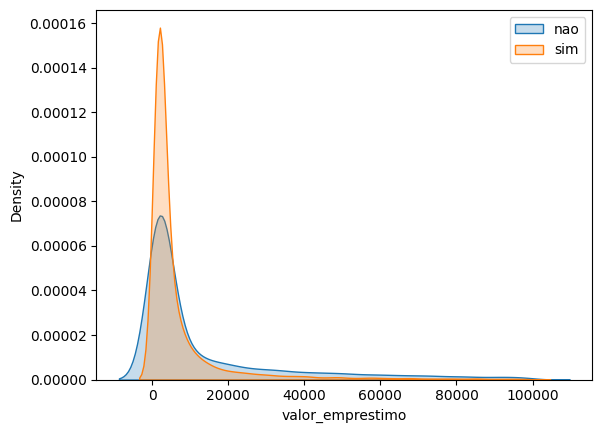

In [72]:

aux = df6[df6['valor_emprestimo']<100000].copy() 


sns.kdeplot(aux[aux['pago']=='nao']['valor_emprestimo'],label='nao',fill=True)
sns.kdeplot(aux[aux['pago']=='sim']['valor_emprestimo'],label='sim',fill=True)
plt.legend()

In [73]:
# Função para categorizar a idade
def categorize_valor_emprestimo(valor_emprestimo):
    if valor_emprestimo <= 20000:
        return 'Até 20000'
    else:
        return 'mais de 20000'

# Adicionando uma nova coluna 'categoria_idade' ao DataFrame
df6['categoria_emprestimo'] = df6['valor_emprestimo'].apply(categorize_valor_emprestimo)

# Agora você pode usar pd.crosstab para analisar as categorias de idade
crosstab_result = pd.crosstab(df6['categoria_emprestimo'], df6['pago'],normalize='index')
print(crosstab_result)

pago                       nao       sim
categoria_emprestimo                    
Até 20000             0.180003  0.819997
mais de 20000         0.431811  0.568189


Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG FALSO

pago,nao,sim
estado,,
espirito santo,2411,9443
minas gerais,2418,9503
rio de janeiro,2424,9395
sao paulo,2385,9488


pago,nao,sim
estado,,
espirito santo,0.203391,0.796609
minas gerais,0.202835,0.797165
rio de janeiro,0.205093,0.794907
sao paulo,0.200876,0.799124


<Axes: xlabel='estado'>

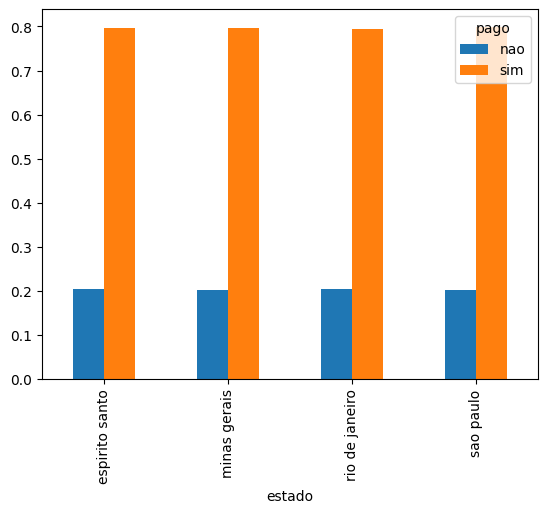

In [74]:
display(pd.crosstab(aux['estado'],aux['pago']))
display(pd.crosstab(aux['estado'],aux['pago'],normalize='index'))
display(pd.crosstab(aux['estado'],aux['pago'],normalize='index').plot(kind='bar'))   

8- ANALISE DE CORRELAÇÃO

In [75]:
df7 = df6.copy()

Variaveis Númericas X Variaveis Númericas

In [76]:
num_attributes= df7.select_dtypes(include=['int32','int64','float32','float64'])
num_attributes = num_attributes.drop('id',axis=1)

<Axes: >

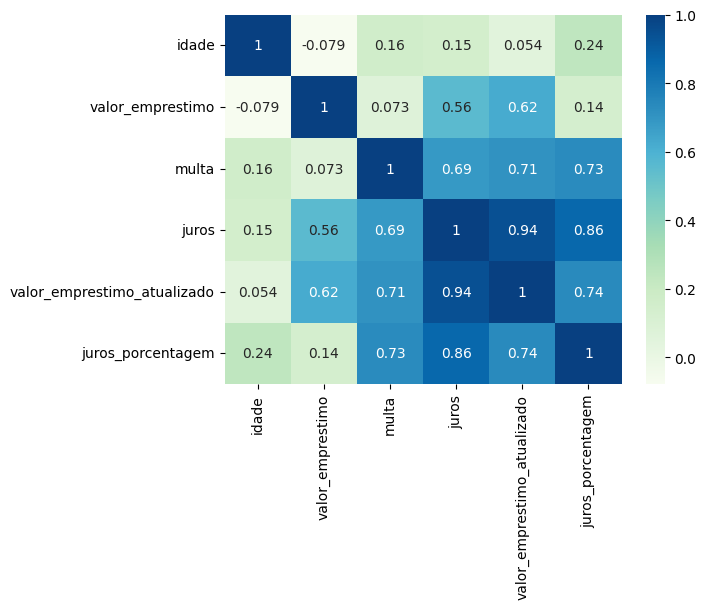

In [77]:
#Correlação de Spearman:
#Use a correlação de Spearman quando você tem variáveis ordinais, de classificação ou quando suspeita que a relação entre as variáveis não é linear.
sns.heatmap(num_attributes.corr('spearman'),cmap= 'GnBu', annot=True)

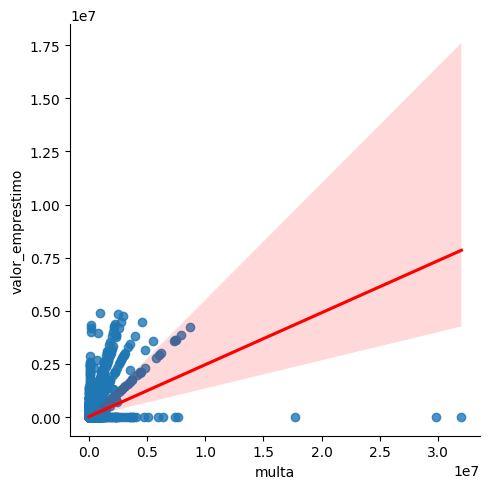

In [78]:
#Utilizar esse grafico (nos casos em que for usar a correlação de pearson) para entender melhor as correlaçoes exppostas no grafico de heatmap
#ex: no grafico de heatmap a correlação entre multa(eixo y) e valor emprestimo (eixo x) é de 0.073 oque indica uma correlação fraca (quanto mais perto de zero mais fraca) e diretamente proporcional (positiva). Ou seja quanto maior a muta maior o valor do emprestimo
sns.lmplot(x='multa', y='valor_emprestimo', data=df7, line_kws={'color': 'red'})

Variaveis Categoricas X Variaveis Categoricas

In [79]:
cat_attributes = df2.select_dtypes(exclude=['int32','int64','float32','float64', 'datetime64[ns]'])
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []

    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]

        confusion_matrix = pd.crosstab(cat_attributes[ref], cat_attributes[feat])
        corr = cramer_v(confusion_matrix.values)

        corr_list.append(corr)

    corr_dict[ref]= corr_list

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'dependentes'),
  Text(0, 1.5, 'estado_civil'),
  Text(0, 2.5, 'conta_poupanca'),
  Text(0, 3.5, 'conta_salario'),
  Text(0, 4.5, 'cheque_sem_fundo'),
  Text(0, 5.5, 'conta_conjunta'),
  Text(0, 6.5, 'pago'),
  Text(0, 7.5, 'genero'),
  Text(0, 8.5, 'estado')])

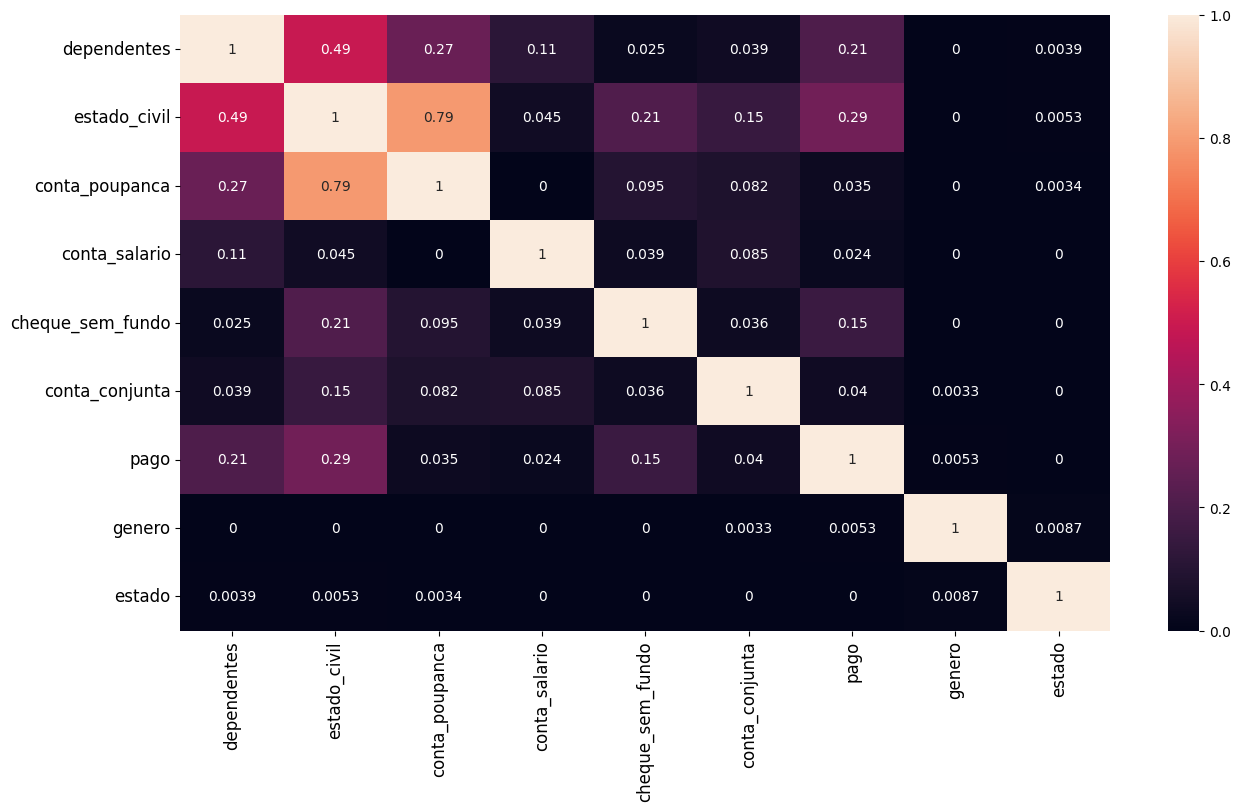

In [80]:
d = pd.DataFrame(corr_dict)
d= d.set_index(d.columns)

plt.figure(figsize=[15,8])
sns.heatmap(d,annot=True)

plt.xticks(rotation=90,fontsize=12)
plt.yticks(rotation=360,fontsize=12)

9- SEPARAR DADOS EM TREINO-VALIDAÇÃO-TESTE

In [81]:
df8 = df7.copy()

In [82]:
df8.head()

,dependentes,estado_civil,idade,conta_poupanca,conta_salario,cheque_sem_fundo,conta_conjunta,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,data,estado,juros_porcentagem,categoria_idade,categoria_emprestimo
0,S,solteiro,36,S,N,S,N,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,2020-01-01,minas gerais,0.715042,Até 59 anos,Até 20000
1,N,solteiro,39,S,N,N,N,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,2020-01-01,espirito santo,0.183175,Até 59 anos,mais de 20000
2,S,solteiro,26,S,N,N,N,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,2020-01-01,sao paulo,0.610616,Até 59 anos,mais de 20000
3,N,casado(a) com comunhao de bens,23,N,N,S,N,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,2020-01-01,sao paulo,2.092722,Até 59 anos,Até 20000
4,S,solteiro,33,S,N,S,N,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,2020-01-01,espirito santo,0.022295,Até 59 anos,Até 20000


In [83]:
#Precisamos transformar o conteudo da coluna 'pago' de 'sim e não' para 0 e 1, pois utilizarei modelo de regressão logistica e ele não entender targets não numericos

def label_pago(x):

    if x=='sim':
        return 0
    else:
        return 1

df8['pago']= df8['pago'].apply(label_pago)
    

In [84]:
df8['pago'].head()

0    0
1    0
2    0
3    0
4    0
Name: pago, dtype: int64

In [85]:
#separando os dados em treino, validação e teste
#20% dos dados de df8 serão teste e 80% serão treinamento. stratify garante que a proporção de empréstimos pagos e não pagos seja mantida em ambos os conjuntos de treinamento e teste evitando desbalanceamento entre as bases

train_set, test_set = train_test_split(df8, test_size =0.2,random_state=42, stratify =df8['pago'] )

In [86]:
# Salva o DataFrame no arquivo CSV na mesma pasta do script
train_set.to_csv(os.path.join(os.getcwd(), 'train_data.csv'), index=False)
test_set.to_csv(os.path.join(os.getcwd(), 'test_data.csv'), index=False)

10- FEATURE SELECTION

In [94]:
df9 = pd.read_csv('train_data.csv').drop(['id','multa','juros','valor_emprestimo','juros_porcentagem'],axis=1).copy()

In [95]:
df9.columns

Index(['dependentes', 'estado_civil', 'idade', 'conta_poupanca',
       'conta_salario', 'cheque_sem_fundo', 'conta_conjunta',
       'valor_emprestimo_atualizado', 'pago', 'genero', 'data', 'estado',
       'categoria_idade', 'categoria_emprestimo'],
      dtype='object')

In [ ]:
10.1 Logistic Regression

In [100]:
#pago é minha variavel alvo
columns_select = ['dependentes','estado_civil','idade','conta_conjunta','cheque_sem_fundo','valor_emprestimo_atualizado','pago']

In [101]:
#copiando df
df10_lr = df9[columns_select].copy()

In [105]:
#otimizando dados das variaveis vamos utilizar 'from feature_engine.encoding import RareLabelEncoder'
df10_lr['estado_civil'].value_counts(normalize=True)
#separado judicialmente, divorciado, viuvo(a) tem valores muito baixos oque não permite muitos insights. Por isso vamos junta-los a 'outros'         

estado_civil
solteiro                                  0.537141
casado(a) com comunhao parcial de bens    0.270720
casado(a) com comunhao de bens            0.156646
casado(a) com separacao de bens           0.031092
separado judicialmente                    0.001519
divorciado                                0.001158
viuvo(a)                                  0.000927
outros                                    0.000798
Name: proportion, dtype: float64

In [109]:
#todas as variaveis categoricas (não só estado civil, como visto cima) que possuirem mais de 5 tipos/categorias, e cujos valores dessas categorias forem menor que 0.05 iremos atribuir a variavel'outros'
ce_rare = RareLabelEncoder(n_categories=5,tol=0.05, variables=['estado_civil'],replace_with='outros')

In [111]:
ce_rare.fit(df10_lr) #analisa as categorias da variável 'estado_civil' e decide quais categorias considerar com base nos parâmetros fornecidos (n_categories=5,tol=0.05).

df10_lr=ce_rare.transform(df10_lr) #transformando o dataframe df9_lr usando o ajuste anterior. Durante a transformação, as categorias consideradas "raras" na variável 'estado_civil' serão substituídas pelo valor 'outros'

In [112]:
df10_lr['estado_civil'].value_counts(normalize=True) #conferindo


estado_civil
solteiro                                  0.537141
casado(a) com comunhao parcial de bens    0.270720
casado(a) com comunhao de bens            0.156646
outros                                    0.035494
Name: proportion, dtype: float64

In [128]:
def df11_lr(df,frac):
    x_train_2, x_test_2 = train_test_split(df,test_size =0.2,random_state=42, stratify =df10_lr['pago'] )

    sample = x_train_2[x_train_2['pago'] == 0].sample(frac=frac, random_state=42)
    x_train_2=x_train_2.drop(sample.index)
    print(x_train_2['pago'].value_counts(normalize=True))

    x_train = x_train_2.drop('pago',axis=1)
    t_train = x_train_2['pago']

    y_test = x_test_2['pago']

    return x_train, x_train_2, x_test_2.drop(['pago'],axis=1),y_test


In [142]:
x_train, x_train_2, x_test, y_test = df11_lr(df10_lr,frac=0.7)

#utilizando 70% para ver se os valores ficaram balanceados

pago
0    0.525829
1    0.474171
Name: proportion, dtype: float64


In [143]:
# StandardScaler para 'idade'
ss = StandardScaler()
ss.fit(x_train_2[['idade']].values)
x_train_2['idade'] = ss.transform(x_train_2[['idade']].values)
x_test['idade'] = ss.transform(x_test[['idade']].values)

# PowerTransformer para 'valor_emprestimo'
yj = PowerTransformer(method='yeo-johnson', standardize=True)
yj.fit(x_train_2[['valor_emprestimo_atualizado']].values)
x_train_2['valor_emprestimo_atualizado'] = yj.transform(x_train_2[['valor_emprestimo_atualizado']].values)
x_test['valor_emprestimo_atualizado'] = yj.transform(x_test[['valor_emprestimo_atualizado']].values)


In [144]:
log_reg = smf.logit("pago ~ valor_emprestimo_atualizado + idade + estado_civil + conta_conjunta + dependentes + cheque_sem_fundo", data = x_train_2).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.560318
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   pago   No. Observations:                13957
Model:                          Logit   Df Residuals:                    13948
Method:                           MLE   Df Model:                            8
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                  0.1901
Time:                        13:26:49   Log-Likelihood:                -7820.4
converged:                       True   LL-Null:                       -9655.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [148]:
yhat_lr = log_reg.predict(x_test)
predictions = list(map(round,yhat_lr))

cm = metrics.confusion_matrix(y_test, predictions)
print("confusion_matrix: '\n", cm)

confusion_matrix: '
 [[4562 1554]
 [ 508 1147]]


### 10.2 SELECT KBEST ANOVA (LOGISTIC REGRESSION)

In [150]:
df9 = pd.read_csv('train_data.csv').drop(['id','multa','juros','valor_emprestimo','juros_porcentagem'],axis=1).copy()
columns_select = ['dependentes','estado_civil','idade','conta_conjunta','cheque_sem_fundo','valor_emprestimo_atualizado','pago']
df10_lr = df9[columns_select].copy()



In [151]:
x_train, x_test, y_train, y_test = train_test_split(df10_lr.drop('pago',axis=1),df10_lr['pago'],test_size =0.2,random_state=42, stratify =df10_lr['pago'] )

In [153]:
# StandardScaler para 'idade'
ss = StandardScaler()
ss.fit(x_train[['idade']].values)
x_train['idade'] = ss.transform(x_train[['idade']].values)
x_test['idade'] = ss.transform(x_test[['idade']].values)

# PowerTransformer para 'valor_emprestimo'
yj = PowerTransformer(method='yeo-johnson', standardize=True)
yj.fit(x_train[['valor_emprestimo_atualizado']].values)
x_train['valor_emprestimo_atualizado'] = yj.transform(x_train[['valor_emprestimo_atualizado']].values)
x_test['valor_emprestimo_atualizado'] = yj.transform(x_test[['valor_emprestimo_atualizado']].values)

ce_rare = RareLabelEncoder(n_categories=5,tol=0.05, variables=['estado_civil'],replace_with='outros')
ce_rare.fit(x_train) #analisa as categorias da variável 'estado_civil' e decide quais categorias considerar com base nos parâmetros fornecidos (n_categories=5,tol=0.05).
x_train=ce_rare.transform(x_train) #transformando o dataframe df9_lr usando o ajuste anterior. Durante a transformação, as categorias consideradas "raras" na variável 'estado_civil' serão substituídas pelo valor 'outros'
x_test=ce_rare.transform(x_test) #transformando o dataframe df9_lr usando o ajuste anterior. Durante a transformação, as categorias consideradas "raras" na variável 'estado_civil' serão substituídas pelo valor 'outros'

ce_OHE =OneHotEncoder(variables=['conta_conjunta','dependentes','estado_civil','cheque_sem_fundo'],drop_last=True).fit(x_train)
x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)

c:\Users\Leticia Furletti\anaconda3\envs\Data_science\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable estado_civil is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


In [155]:
def fs_kbest(x_train, y_train, x_test, y_test, model):
    k_vs_score_0 = []
    k_vs_score_1 = []

    for k in range(1, len(x_test.columns) + 1, 1):
        selector = SelectKBest(score_func=f_classif, k=k)

        Xtrain2 = selector.fit_transform(x_train, y_train)
        Xval2 = selector.transform(x_test)

        model.fit(Xtrain2, y_train)

        p = model.predict(Xval2)

        score_0 = round(metrics.f1_score(y_test, p, average=None)[0],3)
        score_1 = round(metrics.f1_score(y_test, p, average=None)[1],3)

        print("k= {} 0 F1_0 = {} - F1_1 = {}".format(k, score_0, score_1))
        k_vs_score_0.append(score_0)
        k_vs_score_1.append(score_1)

    pd.Series(k_vs_score_0, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))
    pd.Series(k_vs_score_1, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))

    plt.title('VISUALIZING METRIC', fontsize=10, weight='bold')
    plt.ylabel("F1 SCORE", fontsize=10, weight='bold')
    plt.xlabel("QTD FEATURES", fontsize=10, weight='bold')

    plt.show()

    selector = SelectKBest(score_func = f_classif, k=len(x_train.columns))
    selector.fit(x_train, y_train)

    pd.Series(selector.scores_, index=x_train.columns).sort_values().plot.barh()
    
    plt.show()

    df_score = pd.DataFrame({'variavel':x_train.columns, 'fs_score':selector.scores_, 'p_value': selector.pvalues_})
    df_score = df_score.sort_values('fs_score', ascending=False).reset_index(drop=True)
    display(df_score)

k= 1 0 F1_0 = 0.738 - F1_1 = 0.425
k= 2 0 F1_0 = 0.78 - F1_1 = 0.491
k= 3 0 F1_0 = 0.786 - F1_1 = 0.504
k= 4 0 F1_0 = 0.78 - F1_1 = 0.497
k= 5 0 F1_0 = 0.796 - F1_1 = 0.517
k= 6 0 F1_0 = 0.796 - F1_1 = 0.516
k= 7 0 F1_0 = 0.796 - F1_1 = 0.518
k= 8 0 F1_0 = 0.796 - F1_1 = 0.518


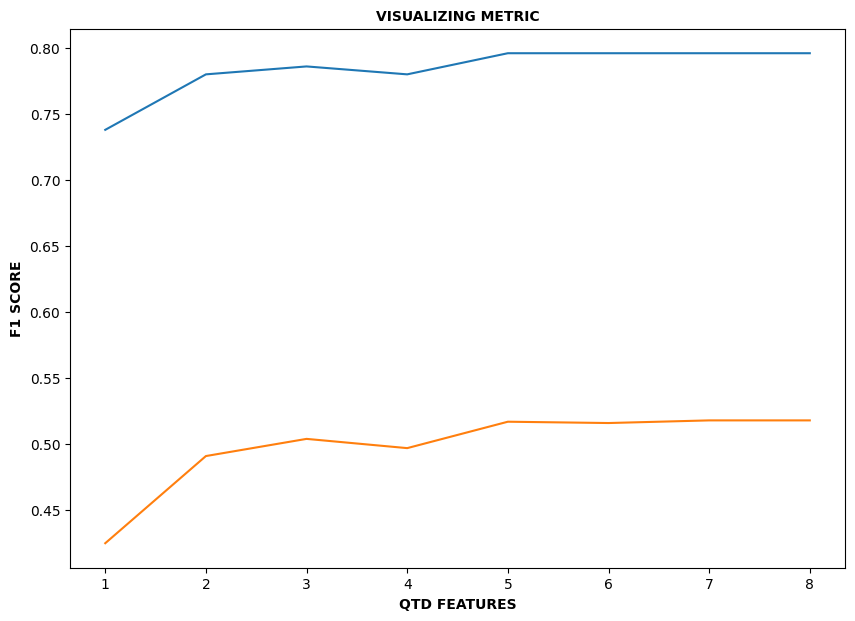

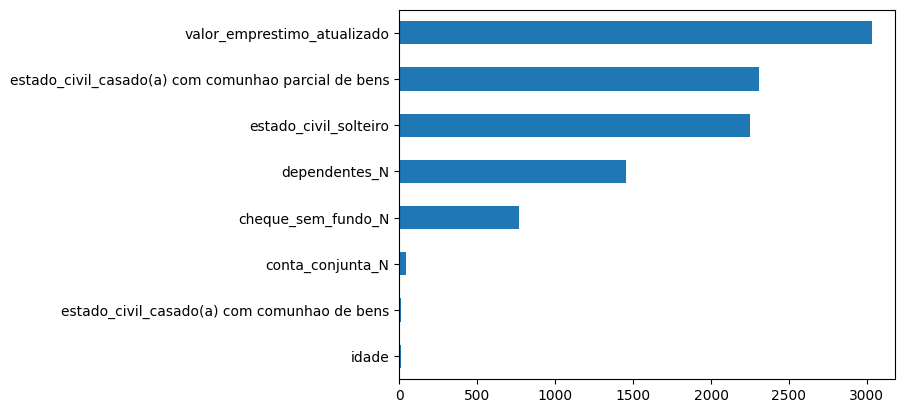

,variavel,fs_score,p_value
0,valor_emprestimo_atualizado,3030.877984,0.000000e+00
1,estado_civil_casado(a) com comunhao parcial de...,2310.296370,0.000000e+00
2,estado_civil_solteiro,2252.493119,0.000000e+00
3,dependentes_N,1457.194867,1.253339e-311
4,cheque_sem_fundo_N,770.260255,1.747998e-167
5,conta_conjunta_N,45.178405,1.829841e-11
6,estado_civil_casado(a) com comunhao de bens,11.793905,5.950249e-04
7,idade,9.240297,2.369434e-03


In [156]:
fs_kbest(x_train, y_train, x_test, y_test, model = LogisticRegression(class_weight='balanced'))

10.2 DECISION TREE

10.2.1 RECURSIVE FEATURE ADDITION

In [158]:
columns_select = ['dependentes','estado_civil','idade','conta_conjunta','cheque_sem_fundo','valor_emprestimo_atualizado','pago']
df10_dt = df9[columns_select].copy()

In [176]:
x_train, x_test, y_train, y_test = train_test_split(df10_dt.drop('pago',axis=1),df10_dt['pago'],test_size =0.2,random_state=42, stratify =df10_lr['pago'] )

In [177]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)
x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_mean = MeanEncoder(variables=['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)
x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

In [179]:
ce_mean.encoder_dict_

{'conta_conjunta': {'N': 0.21619533821454961, 'S': 0.1384850803366488},
 'dependentes': {'N': 0.27766357483078463, 'S': 0.09698275862068965},
 'estado_civil': {'casado(a) com comunhao de bens': 0.2315179126113067,
  'casado(a) com comunhao parcial de bens': 0.3888560972730492,
  'outros': 0.2767527675276753,
  'solteiro': 0.11415224291788945},
 'cheque_sem_fundo': {'N': 0.09542038848716858, 'S': 0.2474196770434493}}

In [186]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5)
rfa = RecursiveFeatureAddition(estimator, scoring='roc_auc', cv=kf, threshold=0.005, confirm_variables=False)
rfa.fit_transform(x_train,y_train)

,estado_civil,cheque_sem_fundo,valor_emprestimo_atualizado
38633,0.114152,0.09542,12999.99
15255,0.114152,0.24742,3091.90
22547,0.231518,0.24742,3315.44
14271,0.114152,0.24742,4305.55
29288,0.114152,0.24742,12934.52
...,...,...,...
852,0.114152,0.24742,4958.20
27337,0.114152,0.09542,2784.56
19111,0.231518,0.24742,133647.71
37121,0.114152,0.09542,1989.14


10.2.2 FEATURE IMPORTANCE

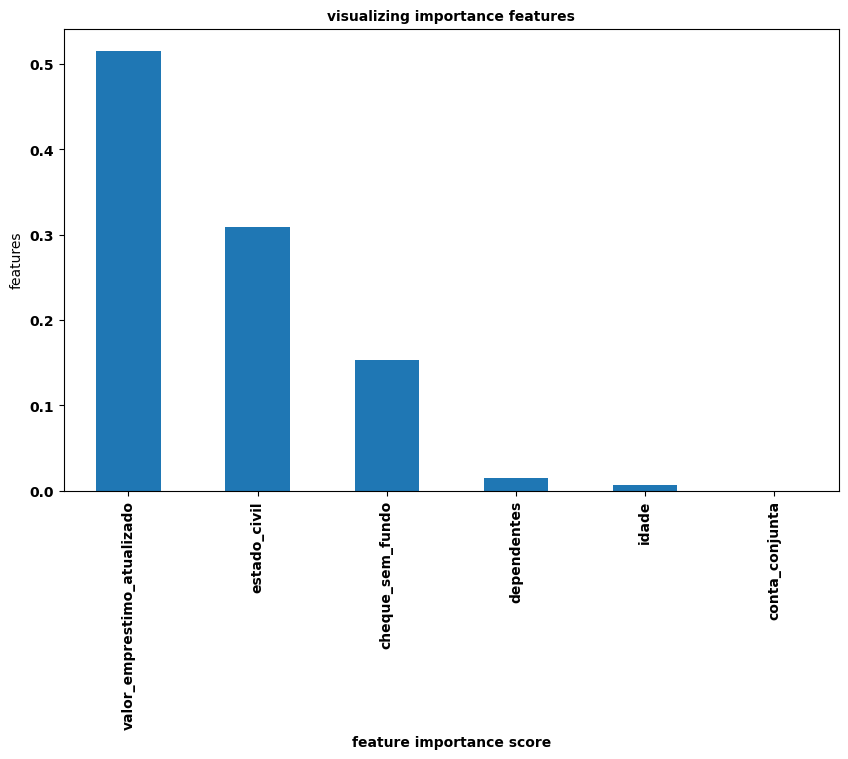

In [193]:
estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5).fit(x_train,y_train)
features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending = False, inplace = True)

features.plot.bar(figsize=(10,6))
plt.xlabel('feature importance score', fontsize=10, weight = 'bold')
plt.ylabel('features')
plt.title('visualizing importance features', fontsize=10, weight = 'bold')

plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()
